In [1]:
file_name = 'data_bubonic_FCFP6_1024.csv'
file_path = '../Data/MolSync/bayesian1/'+file_name # file
bins = 1024 # bins in fingerprints
n_split = 10 # desirable number of batches for DNN fit
test_set_size = 0.2 # approximate portion of dataset which will be used for test dataset 
drop_out=0.5 # drop out, probably we will use 0.5 to make sure no overfitting
seed = 0 # set to a value, thus the results are reproducible
max_layers = 5
name_reg = '' # continuse target name if there is any
sub_folder = '20170508_results_bin1024' # sub-folder to save results and models 
gpu = 'gpu:0'# define which gpu use for computing

In [2]:
import os
if not os.path.isdir(sub_folder):
    ! mkdir $sub_folder # make a new forlder to save the results

## DNN Classifiers

**Note: train dataset prepared with stratified shuffle for batch size=dataset/5**

In [3]:
print("\nDeep Neural Networks with maximum %d hidden layers and %d nodes per layer. \n" % (max_layers, bins))


Deep Neural Networks with maximum 5 hidden layers and 1024 nodes per layer. 



In [4]:
# Importing nesessary modules
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import time
import sys
import random
from itertools import cycle
from IPython.display import SVG

# Load tensorflow
import tensorflow as tf
from tensorflow.contrib import learn

# Load keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.regularizers import WeightRegularizer, l2
from keras.callbacks import ReduceLROnPlateau, Callback, EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam, Nadam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.utils.visualize_util import model_to_dot
from keras.layers.advanced_activations import LeakyReLU, SReLU

# Load sklearn methods
from sklearn import model_selection
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score, accuracy_score, make_scorer
from sklearn.metrics import cohen_kappa_score, matthews_corrcoef, precision_score, recall_score
from sklearn.metrics import r2_score, confusion_matrix, brier_score_loss, average_precision_score
from sklearn import utils

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

# font and othere plot settings
plt.style.use('seaborn-darkgrid')
sns.set_context("poster")
plt.rcParams['font.family'] = 'sans-serif'

# set memory allocation base on demand from tensorflow and keras model
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.


## Plotting helper functions

In [5]:
class BatchLogger(Callback):
    def __init__(self, display):
        '''
        display: display progress every 5% 
        '''
        self.seen = 0
        self.display = display

    def on_batch_end(self,batch, logs={}):
        total_steps = self.params['nb_sample'] * (self.params['nb_epoch'] - 1)
        self.seen += logs.get('size', 0)
        percent_check = total_steps * self.display / 100
        if self.seen % percent_check == 0:
            all_param = (100*self.seen/total_steps, logs.get('loss'))
            print("%d%% Done  Loss: %0.4f" % all_param)

In [6]:
# plot loss from train history
def plot_train_history(model):
    """
    input: model training history from keras
    output: plot loss vs epochs
    """
    lw = 2
    plt.figure(figsize=(8, 6))
    plt.plot(model.epoch, model.history['loss'],c='b', label="Train loss", lw=lw)
    plt.ylim([0.0, max(model.history['loss'])])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

# helper for ROC plotting and AUC saving for the model
def ROC_plot(model, model_name, X_train, y_train_class, X_test, y_test_class, batch_size=None, lw=2, DNN=False):
    """
    This function will plot ROC curves for a model
    input:
    model: tuned classification model
    X_train, y_train, X_test, y_test: pre-processed dataseries, dataframes, or nupy arrays sutable for this model
    DNN: flag for classic ML or DNN model, default is False
    Output:
    dictionary: ('train', 'AUC'): roc_auc_tr*100, ('train', 'ACC'): ACC_tr, ('train', 'f1-score'): f1_tr, 
            ('train', 'Cohen_Kappa'): cohen_kappa_tr, ('train', 'Matthews_corr'): matthews_corr_tr, 
             ('train', 'Precision'): precision_tr, ('train', 'Recall'): recall_tr, 
            ('test', 'AUC'): roc_auc_ts*100, ('test', 'ACC'): ACC_ts, ('test', 'f1-score'): f1_ts, 
            ('test', 'Cohen_Kappa'): cohen_kappa_ts, ('test', 'Matthews_corr') : matthews_corr_ts, 
            ('test', 'Precision') : precision_ts, ('test', 'Recall'): recall_ts
    """
    if DNN:
        classes_tr = model.predict_classes(X_train.values, batch_size=batch_size, verbose=0)
        classes_ts = model.predict_classes(X_test.values, batch_size=y_test_class.shape[0], verbose=0)
        proba_tr = model.predict_proba(X_train.values, batch_size=batch_size, verbose=0)[:, 0]
        proba_ts = model.predict_proba(X_test.values, batch_size=y_test_class.shape[0], verbose=0)[:, 0]
    else:
        classes_tr = model.predict(X_train.values)
        classes_ts = model.predict(X_test.values)       
        proba_tr = model.predict_proba(X_train.values)[:, 1]
        proba_ts = model.predict_proba(X_test.values)[:, 1]
    
    ACC_tr = 100*accuracy_score(y_train_class, classes_tr)
    ACC_ts = 100*accuracy_score(y_test_class, classes_ts)
    accuracy = "train Accuracy = %.2f%%, test Accuracy = %.2f%%" % (ACC_tr, ACC_ts)
    
    f1_tr = 100*f1_score(y_train_class, classes_tr)
    f1_ts = 100*f1_score(y_test_class, classes_ts)
    f1_scores = "train f1-score = %.2f%%, test f1-score = %.2f%%" % (f1_tr, f1_ts)
    
    # train classification results 
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train_class, proba_tr)                               
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    # test classification results 
    fpr_ts, tpr_ts, thresholds_ts = roc_curve(y_test_class, proba_ts)                               
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    
    # Cohens Kappa
    cohen_kappa_tr = cohen_kappa_score(y_train_class, classes_tr)
    cohen_kappa_ts = cohen_kappa_score(y_test_class, classes_ts)
    cohen_kappa = "train Cohen Kappa = %.2f, test Cohen Kappa = %.2f" % (cohen_kappa_tr, cohen_kappa_ts)
    
    # Matthews correlation coefficient
    matthews_corr_tr = matthews_corrcoef(y_train_class, classes_tr)
    matthews_corr_ts = matthews_corrcoef(y_test_class, classes_ts)
    matthews_corr = "train Matthews correlation coefficient = %.2f, test Matthews correlation coefficient = %.2f" % (matthews_corr_tr, matthews_corr_ts)    

    # Precision
    precision_tr = precision_score(y_train_class, classes_tr)
    precision_ts = precision_score(y_test_class, classes_ts)
    precision = "train Precision = %.2f, test Precision = %.2f" % (precision_tr, precision_ts)    

    # Recall
    recall_tr = recall_score(y_train_class, classes_tr)
    recall_ts = recall_score(y_test_class, classes_ts)
    recall = "train Recall = %.2f, test Recall = %.2f" % (recall_tr, recall_ts)
    
    # print all metrics for test and test
    print('\nModelling results: \n%s \n%s \n%s \n%s \n%s \n%s \n' % (accuracy, f1_scores, cohen_kappa, 
                                                                matthews_corr, precision, recall))    
    
    # plot two ROC: train, test and train only
    fig = plt.figure(figsize=(13, 6))
    
    # Train and test ROC
    fig.add_subplot(1, 2, 1)    
    # plot 50%
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k')
    # plot train ROC
    plt.plot(fpr_tr, tpr_tr, lw=lw, color='r',
                 label='ROC %s (area = %0.2f%%)' % ('train', (roc_auc_tr*100)))
    # plot test ROC
    plt.plot(fpr_ts, tpr_ts, lw=lw+1, color='b', 
                 label='ROC %s (area = %0.2f%%)' % ('test', (roc_auc_ts*100)))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for \n %s classifier \n' % model_name)
    plt.legend(loc="lower right")
    
    # Train ROC
    fig.add_subplot(1, 2, 2)    
    # plot 50%
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k')
    # plot train ROC
    plt.plot(fpr_tr, tpr_tr, lw=lw, color='r',
                 label='ROC (area = %0.2f%%)' % (roc_auc_tr*100))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for \n %s classifier \n' % model_name)
    plt.legend(loc="lower right")
    
    plt.show()
       
    return {('train', 'AUC'): roc_auc_tr*100, ('train', 'ACC'): ACC_tr, ('train', 'f1-score'): f1_tr, 
            ('train', 'Cohen_Kappa'): cohen_kappa_tr, ('train', 'Matthews_corr'): matthews_corr_tr, 
             ('train', 'Precision'): precision_tr, ('train', 'Recall'): recall_tr, 
            ('test', 'AUC'): roc_auc_ts*100, ('test', 'ACC'): ACC_ts, ('test', 'f1-score'): f1_ts, 
            ('test', 'Cohen_Kappa'): cohen_kappa_ts, ('test', 'Matthews_corr') : matthews_corr_ts, 
            ('test', 'Precision') : precision_ts, ('test', 'Recall'): recall_ts}


def plot_reg_target(df_reg_target, name):
    """
    plot histogram of the continues target
    input:
    df_reg_target: as dataframe
    name: name of the target
    """
    df_reg_target.hist(bins=20, figsize=(8, 6), edgecolor='b')
    plt.title(name+" Histogram, bin=20 \n")
    plt.xlabel(name)
    plt.ylabel("Frequency")
    return 


def plot_reg_results(model_reg, model_name, name_reg, X, y_reg, test=True):
    """
    Function plots Actual values vs predicted values for regression models
    input:
    model: sklearn or keras (DNN) trained regression model 
    model_name: string, name of the model
    name_reg: string, name of y variable
    X, y_reg: pre-processed dataseries, dataframes, or nupy arrays sutable for this model
    test: test dataset True or False
    output:
    dictionary: {'R2_squared' : r2_results}, where r2_results is a coefficient of determination R^2 
    """
    if test:
        ds_type = 'test'
    else:
        ds_type = 'train'
    predict_model_reg = model_reg.predict(X.values)
    r2_results = r2_score(y_reg, predict_model_reg)
    plt.figure(figsize=(10, 8))
    sns.regplot(predict_model_reg, y_reg, ci=False)
    plt.legend([model_name+' regression', name_reg], loc=2)
    plt.xlabel("Actual values of "+name_reg)
    plt.ylabel("Predicted values of "+name_reg)
    plt.title("Predicted vs Actual values for %s dataset \n coefficient of determination R^2 = %.4f" % (ds_type, r2_results))
    return {'R2_squared' : r2_results}

def plot_heat_maps_cm(cm_tr, cm_ts):
    """
    plots confusion matrix heat map
    input:
    confusion matrix
    """
    fig = plt.figure(figsize=(13,4))
    fig.add_subplot(1, 2, 1)
    sns.heatmap(cm_tr, annot=True, annot_kws={'fontsize': 12},  fmt = 'd')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    sns.plt.title('Confusion matrix for %s dataset \n' % 'train')
    
    fig.add_subplot(1, 2, 2)
    sns.heatmap(cm_ts, annot=True, annot_kws={'fontsize': 12},  fmt = 'd')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    sns.plt.title('Confusion matrix for %s dataset \n' % 'test')
    plt.show()
    return None


def plot_cm_final(model, model_name, X_tr, y_tr, X_ts, y_ts, batch_size=None, DNN=True):
    """
    plotting final confusion matrix
    """
    if DNN:
        y_pred_ts = model.predict_classes(X_ts.values, batch_size=X_ts.shape[0], verbose=0)
        y_pred_tr = model.predict_classes(X_tr.values, batch_size=batch_size, verbose=0)
    else:
        y_pred_tr = model.predict(X_train.values)
        y_pred_ts = model.predict(X_test.values) 
    # confusion matixes
    cm_ts = confusion_matrix(y_ts, y_pred_ts)
    cm_tr = confusion_matrix(y_tr, y_pred_tr)
    print('\n'+model_name+'\n')
    plot_heat_maps_cm(cm_tr, cm_ts)
    return None

def test_results_plot(model, model_name, X_test, y_test_class, batch_size=None, lw=2, DNN=False):
    """
    This function will plot test ROC curve and confusion matrix for a model
    input:
    model: sklearn tuned classification model
    X_test, y_test: pre-processed dataseries, dataframes, or nupy arrays sutable for this model
    DNN: flag for classic ML or DNN model, default is False
    Output:
    dictionary: 'AUC': roc_auc_ts*100, 'ACC': ACC_ts, 'f1-score': f1_ts, 'Cohen_Kappa': cohen_kappa_ts, 
            'Matthews_corr' : matthews_corr_ts, 'Precision': precision_ts, 'Recall': recall_ts
    """
    if DNN:
        classes_ts = model.predict_classes(X_test.values, batch_size=y_test_class.shape[0], verbose=0)
        proba_ts = model.predict_proba(X_test.values, batch_size=y_test_class.shape[0], verbose=0)[:, 0]
    else:
        classes_ts = model.predict(X_test.values)       
        proba_ts = model.predict_proba(X_test.values)[:, 1]
    
    ACC_ts = 100*accuracy_score(y_test_class, classes_ts)
    accuracy = "test Accuracy = %.2f%%" % ( ACC_ts)
    
    f1_ts = 100*f1_score(y_test_class, classes_ts)
    f1_scores = "test f1-score = %.2f%%" % (f1_ts)
    
    # test classification results 
    fpr_ts, tpr_ts, thresholds_ts = roc_curve(y_test_class, proba_ts)                               
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    
    # Cohens Kappa
    cohen_kappa_ts = cohen_kappa_score(y_test_class, classes_ts)
    cohen_kappa = "test Cohen Kappa = %.2f" % (cohen_kappa_ts)
    
    # Matthews correlation coefficient
    matthews_corr_ts = matthews_corrcoef(y_test_class, classes_ts)
    matthews_corr = "test Matthews correlation coefficient = %.2f" % (matthews_corr_ts)    

    # Precision
    precision_ts = precision_score(y_test_class, classes_ts)
    precision = "test Precision = %.2f" % (precision_ts)    

    # Recall
    recall_ts = recall_score(y_test_class, classes_ts)
    recall = "test Recall = %.2f" % (recall_ts)
    
    # print all metrics for test and test
    print('\nModelling results: \n%s \n%s \n%s \n%s \n%s \n%s \n' % (accuracy, f1_scores, cohen_kappa, 
                                                                matthews_corr, precision, recall))    
    
    # plot two ROC: train, test and train only
    fig = plt.figure(figsize=(13, 6))
    
    # Test ROC
    fig.add_subplot(1, 2, 1)    
    # plot 50%
    plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k')
    # plot test ROC
    plt.plot(fpr_ts, tpr_ts, lw=lw+1, color='b', 
                 label='ROC %s (area = %0.2f%%)' % ('test', (roc_auc_ts*100)))
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for \n %s classifier \n' % model_name)
    plt.legend(loc="lower right")
    
    # Train ROC
    fig.add_subplot(1, 2, 2)    
    cm_ts = confusion_matrix(y_test_class, classes_ts)
    sns.heatmap(cm_ts, annot=True, annot_kws={'fontsize': 12},  fmt = 'd')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    sns.plt.title('Confusion matrix for %s dataset \n' % 'test')
    
    plt.show()
       
    return {'AUC': roc_auc_ts*100, 'ACC': ACC_ts, 'f1-score': f1_ts, 'Cohen_Kappa': cohen_kappa_ts, 
            'Matthews_corr' : matthews_corr_ts, 'Precision': precision_ts, 'Recall': recall_ts}

## Deep Neural Networks models builder helper functions

In [7]:
# Function to create model, required for KerasClassifier
def model_DNN_classifier(nh_layers=3, input_dim=1024, num_hidden=[1024, 1024, 1024], 
                 num_labels=1, drop_out=0.1, beta=0.001, l_rate=0.01, momentum=0.9, 
                 init_mode='he_normal', optimizer='SGD', activation='relu', activation_out='sigmoid', 
                 device = 'gpu:0', model_summary=True):
    """
    N layers DNN model with drop out layers for each hidden layer. All the default parameters are for 
    a 3 layer DNN model
    input:
    nh_layers: number of hidden layers
    input_dim: number of features in the dataset
    num_hidden: hidden layers size as a list
    num_labels: number of labels
    drop_out: the same drop out applied for all hidden layers 
    beta: l2 regularization
    l_rate: initial learning rate
    momentum: used only for SGD optimizer
    init_mode: weight initiation method
    optimizer: optimizer name
    activation: hidden layers activation function
    activation_out: out layer activation function
    device: gpu:0 (can accept cpu:0 or gpu:1)
    odel_summary: show the model suumary, default is True)
    output:
    model: keras DNN model
    
    """
    if len(num_hidden) != nh_layers:
        return print("The number of layers nh_layers are not matched to the length of num_hidden")
    if activation == 'relu':
        act = 'relu'
    elif activation == 'tanh':
        act = 'tanh'
    elif activation == 'LeakyReLU':
        act = LeakyReLU()
    elif activation == 'SReLU':  
        act = SReLU()
    else:
        return print("I can't use this activation function to compile a DNN")
    
    with tf.device('/' + device):
        # create model
        model = Sequential(name='model_'+str(nh_layers)+'_layers')
        model.add(Dense(output_dim=num_hidden[0], init=init_mode, input_dim=input_dim, 
                        W_regularizer=l2(l=beta), name='Dense_1'))
        model.add(Activation(act))
        model.add(Dropout(drop_out, name='DropOut_1'))
        for idx in range(nh_layers - 1):
            model.add(Dense(output_dim=num_hidden[idx+1], init=init_mode, 
                            W_regularizer=l2(l=beta), name='Dense_'+str(idx+2)))
            if activation == 'LeakyReLU':
                act = LeakyReLU(input_shape=(num_hidden[idx+1],))
            elif activation == 'SReLU':
                act = SReLU(input_shape=(num_hidden[idx+1],))
            model.add(Activation(act))
            model.add(Dropout(drop_out, name='DropOut_'+str(idx+2)))        
        model.add(Dense(output_dim=num_labels, init=init_mode, 
                        activation=activation_out, W_regularizer=l2(l=beta), name='Output'))
        # compile model
        if optimizer == 'SGD':
            opt = SGD(lr=l_rate, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            opt = Adam(lr=l_rate)
        elif optimizer == 'Nadam':
            opt = Nadam(lr=l_rate)
        else:
            return print("I don't know the %s optimizer" % optimizer)
        if model_summary:
            model.summary()
        model.compile(loss='binary_crossentropy', metrics=['binary_crossentropy', 'fmeasure', 'accuracy'], optimizer=opt)
    return model

In [8]:
# Function to create model, required for KerasClassifier
def model_DNN_regression(nh_layers=3, input_dim=1024, num_hidden=[1024, 1024, 1024], 
                 num_labels=1, drop_out=0.1, beta=0.005, l_rate=0.01, momentum=0.9, 
                 init_mode='lecun_uniform', optimizer='SGD', activation='relu', activation_out='linear', 
                 device = 'gpu:0', model_summary=True):
    """
    N layers DNN model with drop out layers for each hidden layer. All the default parameters are for 
    a 3 layer DNN model
    input:
    nh_layers: number of hidden layers
    input_dim: number of features in the dataset
    num_hidden: hidden layers size as a list
    num_labels: number of labels
    drop_out: the same drop out applied for all hidden layers 
    beta: l2 regularization
    l_rate: initial learning rate
    momentum: used only for SGD optimizer
    init_mode: weight initiation method
    optimizer: optimizer name
    activation: hidden layers activation function
    activation_out: out layer activation function
    device: gpu:0 (can accept cpu:0 or gpu:1)
    
    output:
    model: keras DNN model
    
    """
    if len(num_hidden) != nh_layers:
        return print("The number of layers nh_layers are not matched to the length of num_hidden")
    if activation == 'relu':
        act = 'relu'
    elif activation == 'tanh':
        act = 'tanh'
    elif activation == 'LeakyReLU':
        act = LeakyReLU()
    elif activation == 'SReLU':  
        act = SReLU()
    else:
        return print("I can't use this activation function to compile a DNN")
    
    with tf.device('/' + device):
        # create model
        model = Sequential(name='model_'+str(nh_layers)+'_layers')
        model.add(Dense(output_dim=num_hidden[0], init=init_mode, input_dim=input_dim, 
                        W_regularizer=l2(l=beta), name='Dense_1'))
        model.add(Activation(act))
        model.add(Dropout(drop_out, name='DropOut_1'))
        for idx in range(nh_layers - 1):
            model.add(Dense(output_dim=num_hidden[idx+1], init=init_mode, 
                            W_regularizer=l2(l=beta), name='Dense_'+str(idx+2)))
            if activation == 'LeakyReLU':
                act = LeakyReLU(input_shape=(num_hidden[idx+1],))
            elif activation == 'SReLU':
                act = SReLU(input_shape=(num_hidden[idx+1],))
            model.add(Activation(act))
            model.add(Dropout(drop_out, name='DropOut_'+str(idx+2))) 
        model.add(Dense(output_dim=num_labels, init=init_mode, 
                        activation=activation_out, W_regularizer=l2(l=beta), name='Output'))
        # compile model
        if optimizer == 'SGD':
            opt = SGD(lr=l_rate, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            opt = Adam(lr=l_rate)
        elif optimizer == 'Nadam':
            opt = Nadam(lr=l_rate)
        else:
            return print("I don't know the %s optimizer" % optimizer)
        if model_summary:
            model.summary()            
        model.compile(loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'], optimizer=opt)
    return model

In [9]:
# Function to create model, required for KerasClassifier
def model_DNN_classifier_load(nh_layers=3, input_dim=1024, num_hidden=[1024, 1024, 1024], 
                 num_labels=1, drop_out=0.1, beta=0.001, l_rate=0.01, momentum=0.9, 
                 init_mode='he_normal', optimizer='SGD', activation='relu', activation_out='sigmoid', 
                 device = 'gpu:0', model_summary=False, path=None):
    """
    N layers DNN model with drop out layers for each hidden layer. All the default parameters are for 
    a 3 layer DNN model
    input:
    nh_layers: number of hidden layers
    input_dim: number of features in the dataset
    num_hidden: hidden layers size as a list
    num_labels: number of labels
    drop_out: the same drop out applied for all hidden layers 
    beta: l2 regularization
    l_rate: initial learning rate
    momentum: used only for SGD optimizer
    init_mode: weight initiation method
    optimizer: optimizer name
    activation: hidden layers activation function
    activation_out: out layer activation function
    device: gpu:0 (can accept cpu:0 or gpu:1)
    odel_summary: show the model suumary, default is True)
    output:
    model: keras DNN model
    
    """
    if path == None:
        return print("You need to supply with the path to the weights for this model")
    if len(num_hidden) != nh_layers:
        return print("The number of layers nh_layers are not matched to the length of num_hidden")
    if activation == 'relu':
        act = 'relu'
    elif activation == 'tanh':
        act = 'tanh'
    elif activation == 'LeakyReLU':
        act = LeakyReLU()
    elif activation == 'SReLU':  
        act = SReLU()
    else:
        return print("I can't use this activation function to compile a DNN")
    
    with tf.device('/' + device):
        # create model
        model = Sequential(name='model_'+str(nh_layers)+'_layers')
        model.add(Dense(output_dim=num_hidden[0], init=init_mode, input_dim=input_dim, 
                        W_regularizer=l2(l=beta), name='Dense_1'))
        model.add(Activation(act))
        model.add(Dropout(drop_out, name='DropOut_1'))
        for idx in range(nh_layers - 1):
            model.add(Dense(output_dim=num_hidden[idx+1], init=init_mode, 
                            W_regularizer=l2(l=beta), name='Dense_'+str(idx+2)))
            if activation == 'LeakyReLU':
                act = LeakyReLU(input_shape=(num_hidden[idx+1],))
            elif activation == 'SReLU':
                act = SReLU(input_shape=(num_hidden[idx+1],))
            model.add(Activation(act))
            model.add(Dropout(drop_out, name='DropOut_'+str(idx+2)))        
        model.add(Dense(output_dim=num_labels, init=init_mode, 
                        activation=activation_out, W_regularizer=l2(l=beta), name='Output'))
        # compile model
        if optimizer == 'SGD':
            opt = SGD(lr=l_rate, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            opt = Adam(lr=l_rate)
        elif optimizer == 'Nadam':
            opt = Nadam(lr=l_rate)
        else:
            return print("I don't know the %s optimizer" % optimizer)
        if model_summary:
            model.summary()
        
        model.load_weights(path)
        
        model.compile(loss='binary_crossentropy', metrics=['binary_crossentropy', 'fmeasure', 'accuracy'], optimizer=opt)
    return model

In [10]:
# Function to create model, required for KerasClassifier
def model_DNN_regression_load(nh_layers=3, input_dim=1024, num_hidden=[1024, 1024, 1024], 
                 num_labels=1, drop_out=0.1, beta=0.005, l_rate=0.01, momentum=0.9, 
                 init_mode='lecun_uniform', optimizer='SGD', activation='relu', activation_out='linear', 
                 device = 'gpu:0', model_summary=False, path=None):
    """
    N layers DNN model with drop out layers for each hidden layer. All the default parameters are for 
    a 3 layer DNN model
    input:
    nh_layers: number of hidden layers
    input_dim: number of features in the dataset
    num_hidden: hidden layers size as a list
    num_labels: number of labels
    drop_out: the same drop out applied for all hidden layers 
    beta: l2 regularization
    l_rate: initial learning rate
    momentum: used only for SGD optimizer
    init_mode: weight initiation method
    optimizer: optimizer name
    activation: hidden layers activation function
    activation_out: out layer activation function
    device: gpu:0 (can accept cpu:0 or gpu:1)
    
    output:
    model: keras DNN model
    
    """
    if path == None:
        return print("You need to supply with the path to the weights for this model")
    if len(num_hidden) != nh_layers:
        return print("The number of layers nh_layers are not matched to the length of num_hidden")
    if activation == 'relu':
        act = 'relu'
    elif activation == 'tanh':
        act = 'tanh'
    elif activation == 'LeakyReLU':
        act = LeakyReLU()
    elif activation == 'SReLU':  
        act = SReLU()
    else:
        return print("I can't use this activation function to compile a DNN")
    
    with tf.device('/' + device):
        # create model
        model = Sequential(name='model_'+str(nh_layers)+'_layers')
        model.add(Dense(output_dim=num_hidden[0], init=init_mode, input_dim=input_dim, 
                        W_regularizer=l2(l=beta), name='Dense_1'))
        model.add(Activation(act))
        model.add(Dropout(drop_out, name='DropOut_1'))
        for idx in range(nh_layers - 1):
            model.add(Dense(output_dim=num_hidden[idx+1], init=init_mode, 
                            W_regularizer=l2(l=beta), name='Dense_'+str(idx+2)))
            if activation == 'LeakyReLU':
                act = LeakyReLU(input_shape=(num_hidden[idx+1],))
            elif activation == 'SReLU':
                act = SReLU(input_shape=(num_hidden[idx+1],))
            model.add(Activation(act))
            model.add(Dropout(drop_out, name='DropOut_'+str(idx+2))) 
        model.add(Dense(output_dim=num_labels, init=init_mode, 
                        activation=activation_out, W_regularizer=l2(l=beta), name='Output'))
        # compile model
        if optimizer == 'SGD':
            opt = SGD(lr=l_rate, momentum=momentum, nesterov=True)
        elif optimizer == 'Adam':
            opt = Adam(lr=l_rate)
        elif optimizer == 'Nadam':
            opt = Nadam(lr=l_rate)
        else:
            return print("I don't know the %s optimizer" % optimizer)
        if model_summary:
            model.summary()            
        
        model.load_weights(path)
        
        model.compile(loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'], optimizer=opt)
    return model

## Load Data and prepare train and test datasets. 

In [11]:
df = pd.read_csv(file_path, index_col=0)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,class
count,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,...,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000,139933.000000
mean,0.991317,0.545297,0.972458,0.127054,0.977532,0.116563,0.640564,0.038104,0.293626,0.011463,...,0.370084,0.867644,0.062251,0.021732,0.022975,0.133257,0.028571,0.009576,0.020839,0.001594
std,0.092776,0.497946,0.163656,0.333034,0.148200,0.320900,0.479837,0.191448,0.455424,0.106449,...,0.482829,0.338879,0.241612,0.145807,0.149825,0.339853,0.166597,0.097388,0.142844,0.039888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
df_features = df.ix[:,:bins]
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139933 entries, 0 to 139932
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 1.1 GB


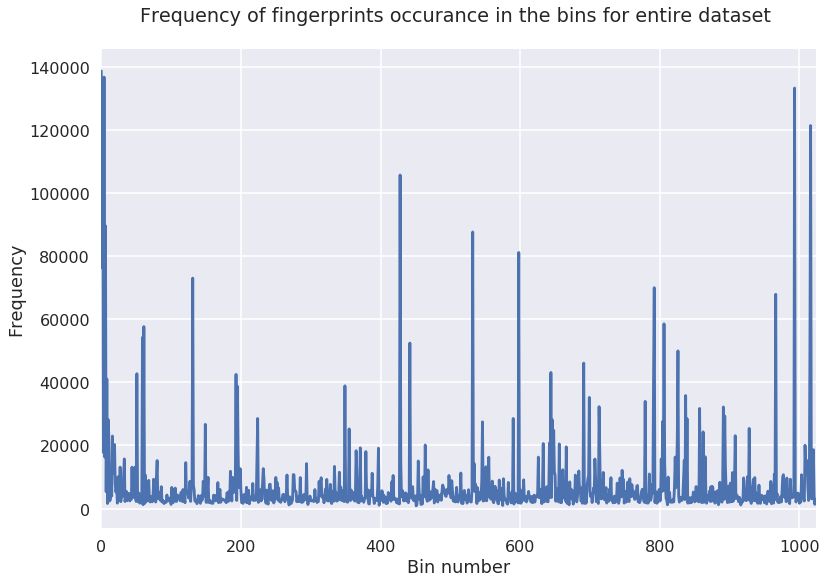

In [13]:
df_features.sum(axis=0).plot()
plt.title("Frequency of fingerprints occurance in the bins for entire dataset \n")
plt.xlabel('Bin number')
plt.ylabel('Frequency')

In [14]:
df_class_target = df['class']

In [15]:
print("\nThere are total %d 'true' labeled molecules out from %d in the dataset \n" % (sum(df_class_target == 1), df_class_target.shape[0]))
print("Baseline prediction (all 'true', metric - accuracy) is %0.2f%%" % (100*sum(df_class_target == 1)/df_class_target.shape[0]))
print("Baseline prediction (all 'false', metric - accuracy) is %0.2f%% \n" % (100 - 100*sum(df_class_target == 1)/df_class_target.shape[0]))


There are total 223 'true' labeled molecules out from 139933 in the dataset 

Baseline prediction (all 'true', metric - accuracy) is 0.16%
Baseline prediction (all 'false', metric - accuracy) is 99.84% 



### Split to train and test datasets. 

In [16]:
# stratified split base on test dataset size (test_set_size) and K-fold split (n_split)
batch_size = int(df_class_target.shape[0]*(1-test_set_size) // n_split) # callculating batch size
train_size = int(batch_size * n_split)
X_train_tmp, X_test_tmp, y_train_class_tmp, y_test_class = model_selection.train_test_split(df.ix[:,0:(bins+1)], 
                                    df_class_target, train_size=train_size, stratify=df_class_target, random_state=seed)
print('train size = %d, batch size = %d, test size = %d' % (train_size, batch_size, y_test_class.shape[0]))

train size = 111940, batch size = 11194, test size = 27993


In [17]:
# prepare dataset indexes for stratified K-fold split
cv = model_selection.StratifiedKFold(shuffle=True, n_splits=n_split, random_state=seed) 
valid_idx = [] # indexes for new train dataset
for (_, valid) in cv.split(X_train_tmp, y_train_class_tmp):
    valid_idx += valid.tolist()

In [18]:
X_train = X_train_tmp.iloc[valid_idx].ix[:,:bins]
print("Train features info:")
print(X_train.info())
X_train.describe()

Train features info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 111940 entries, 65817 to 85396
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 875.4 MB
None


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,...,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000,111940.000000
mean,0.991183,0.544837,0.972423,0.126925,0.977550,0.115991,0.640513,0.038217,0.293657,0.011578,...,0.022253,0.370216,0.867813,0.061819,0.021369,0.022914,0.132839,0.028274,0.009335,0.020779
std,0.093486,0.497988,0.163759,0.332891,0.148141,0.320215,0.479852,0.191720,0.455439,0.106975,...,0.147506,0.482865,0.338695,0.240827,0.144610,0.149630,0.339402,0.165756,0.096168,0.142644
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
X_test = X_test_tmp.ix[:,:bins]
print("Test features info:")
print(X_test.info())
X_test.describe()

Test features info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 27993 entries, 49337 to 84473
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 218.9 MB
None


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,...,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000,27993.000000
mean,0.991855,0.547137,0.972600,0.127568,0.977459,0.118851,0.640767,0.037652,0.293502,0.011003,...,0.021148,0.369557,0.866967,0.063980,0.023184,0.023220,0.134927,0.029757,0.010538,0.021077
std,0.089882,0.497782,0.163248,0.333614,0.148439,0.323619,0.479784,0.190357,0.455375,0.104317,...,0.143881,0.482693,0.339617,0.244722,0.150491,0.150605,0.341651,0.169920,0.102116,0.143643
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
y_train_class = y_train_class_tmp.iloc[valid_idx]
print("Train class info:")
print(y_train_class.describe())

Train class info:
count    111940.000000
mean          0.001590
std           0.039845
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: class, dtype: float64


In [21]:
for i in range(n_split):
    print("True train target fraction for batch %d is %0.2f%%" % (i, 
                                        (y_train_class.iloc[i*batch_size:(i+1)*batch_size].sum()/batch_size)*100))

True train target fraction for batch 0 is 0.16%
True train target fraction for batch 1 is 0.16%
True train target fraction for batch 2 is 0.16%
True train target fraction for batch 3 is 0.16%
True train target fraction for batch 4 is 0.16%
True train target fraction for batch 5 is 0.16%
True train target fraction for batch 6 is 0.16%
True train target fraction for batch 7 is 0.16%
True train target fraction for batch 8 is 0.15%
True train target fraction for batch 9 is 0.15%


In [22]:
print("Test class info:")
print(y_test_class.describe())

Test class info:
count    27993.000000
mean         0.001608
std          0.040063
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: class, dtype: float64


## The following datasets are ready for training and testing:
- X_train
- X_test
- y_train_class
- y_test_class
- y_train_reg
- y_test_reg

## Train Deep Neural Networks models, all trainings use batches and early stopping

In [23]:
# dictionary to save all the model performance characteristics
DNN_performance = {} # we can use it later if needed

### Prepare weights for fitting

In [24]:
def cw_to_dict(y_class):
    """
    input: 1D array, labels
    output: balanced class weight dictionary
    """
    cw = utils.compute_class_weight('balanced', [0, 1], y_class) #compute class weight
    cw_dict = {}
    for idx in range(len(cw)):
        cw_dict[idx] = cw[idx] 
    return cw_dict

In [25]:
# dictionary of weights
cw_tr_dict = cw_to_dict(y_train_class)
cw_ts_dict = cw_to_dict(y_test_class)
print("Train class weights: \n", cw_tr_dict)
print("Test class weights: \n", cw_ts_dict)

Train class weights: 
 {0: 0.50079633506916488, 1: 314.43820224719099}
Test class weights: 
 {0: 0.50080506655216828, 1: 311.03333333333336}


In [26]:
# lists of weights for eash sample
cw_tr = [cw_tr_dict[idx] for idx in y_train_class]
cw_ts = [cw_ts_dict[idx] for idx in y_test_class]

## Train, validate, and test DNN


Training model with 2 hidden layers, and 1024 nodes per layer 

Training on gpu:0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Dense_1 (Dense)                  (None, 1024)          1049600     dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 1024)          0           Dense_1[0][0]                    
____________________________________________________________________________________________________
DropOut_1 (Dropout)              (None, 1024)          0           activation_1[0][0]               
____________________________________________________________________________________________________
Dense_2 (Dense)                  (None, 1024)          1049600     DropOut_1[0][0]                  
________

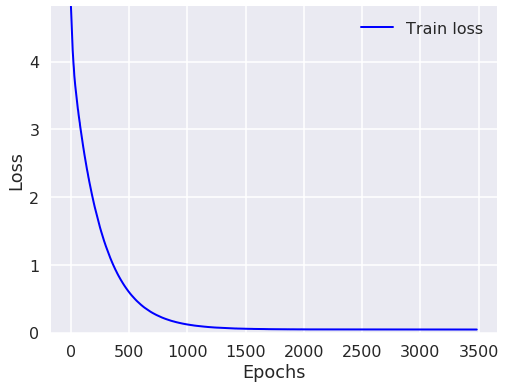


Modelling results: 
train Accuracy = 99.91%, test Accuracy = 99.68% 
train f1-score = 77.56%, test f1-score = 21.05% 
train Cohen Kappa = 0.78, test Cohen Kappa = 0.21 
train Matthews correlation coefficient = 0.80, test Matthews correlation coefficient = 0.21 
train Precision = 0.63, test Precision = 0.17 
train Recall = 1.00, test Recall = 0.27 



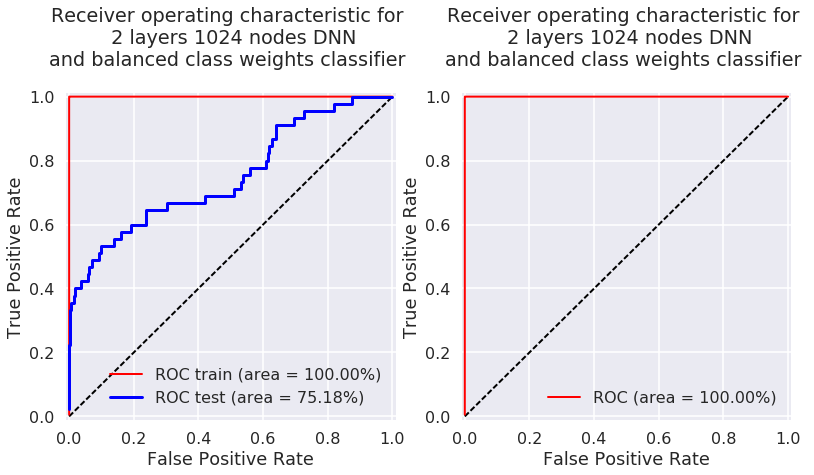


2 layers 1024 nodes DNN



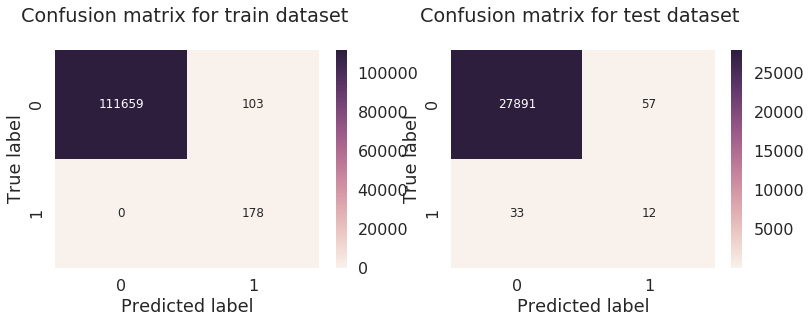


 


Training model with 3 hidden layers, and 1024 nodes per layer 

Training on gpu:0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Dense_1 (Dense)                  (None, 1024)          1049600     dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_3 (Activation)        (None, 1024)          0           Dense_1[0][0]                    
____________________________________________________________________________________________________
DropOut_1 (Dropout)              (None, 1024)          0           activation_3[0][0]               
____________________________________________________________________________________________________
Dense_2 (Dense)                  (None, 1024)          1049600     DropOut_1[0][0]                  
____

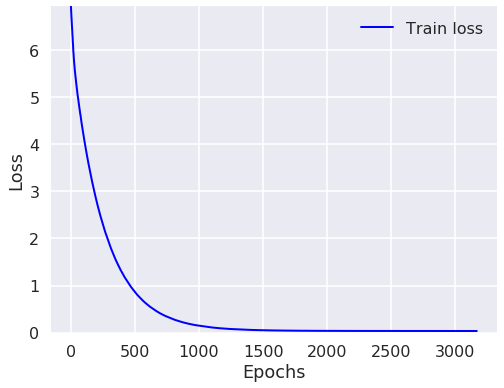


Modelling results: 
train Accuracy = 99.96%, test Accuracy = 99.74% 
train f1-score = 88.34%, test f1-score = 23.16% 
train Cohen Kappa = 0.88, test Cohen Kappa = 0.23 
train Matthews correlation coefficient = 0.89, test Matthews correlation coefficient = 0.23 
train Precision = 0.79, test Precision = 0.22 
train Recall = 1.00, test Recall = 0.24 



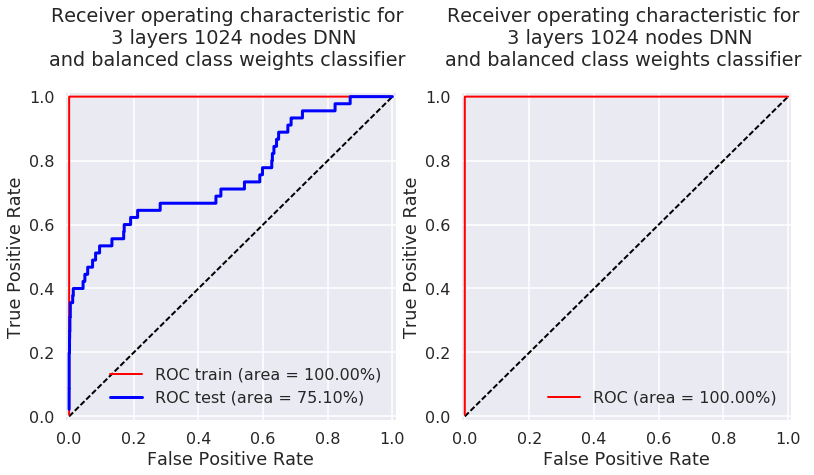


3 layers 1024 nodes DNN



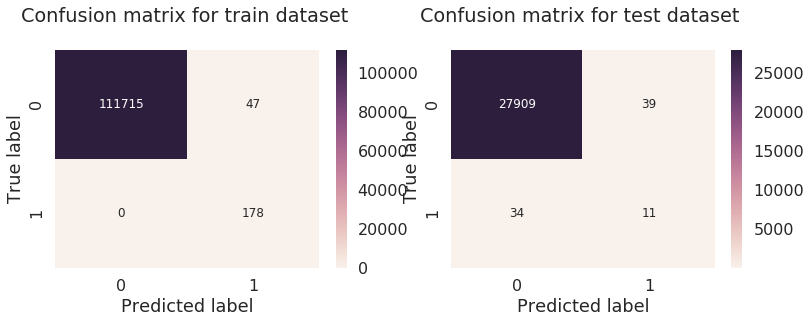


 


Training model with 4 hidden layers, and 1024 nodes per layer 

Training on gpu:0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Dense_1 (Dense)                  (None, 1024)          1049600     dense_input_3[0][0]              
____________________________________________________________________________________________________
activation_6 (Activation)        (None, 1024)          0           Dense_1[0][0]                    
____________________________________________________________________________________________________
DropOut_1 (Dropout)              (None, 1024)          0           activation_6[0][0]               
____________________________________________________________________________________________________
Dense_2 (Dense)                  (None, 1024)          1049600     DropOut_1[0][0]                  
____

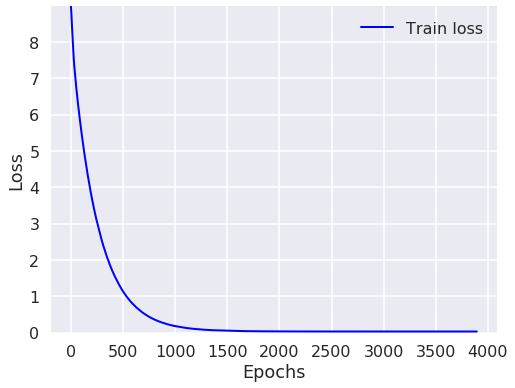


Modelling results: 
train Accuracy = 99.98%, test Accuracy = 99.77% 
train f1-score = 93.19%, test f1-score = 25.29% 
train Cohen Kappa = 0.93, test Cohen Kappa = 0.25 
train Matthews correlation coefficient = 0.93, test Matthews correlation coefficient = 0.25 
train Precision = 0.87, test Precision = 0.26 
train Recall = 1.00, test Recall = 0.24 



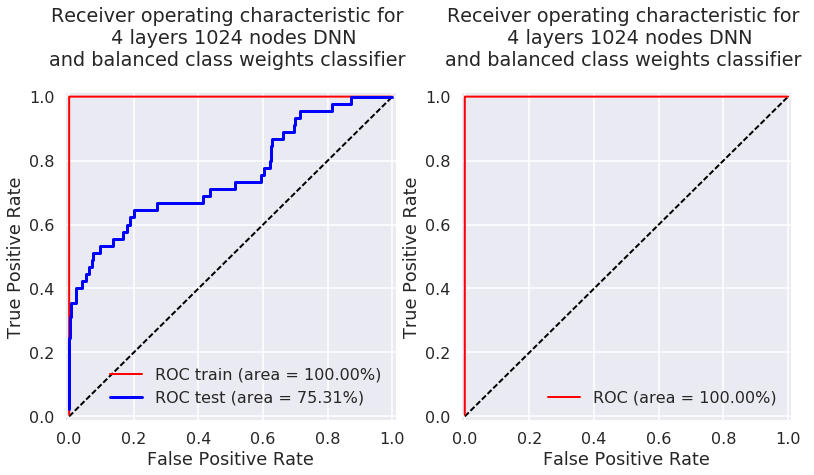


4 layers 1024 nodes DNN



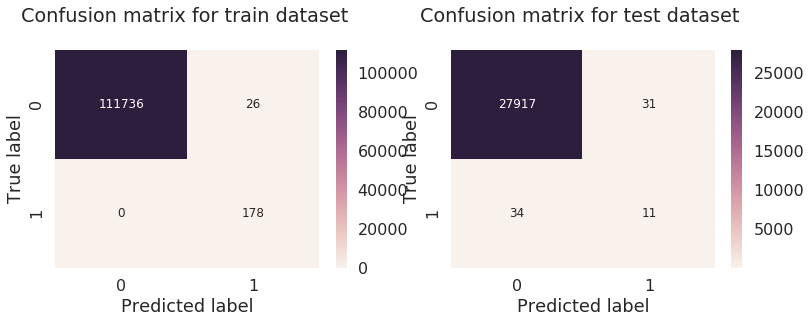


 


Training model with 5 hidden layers, and 1024 nodes per layer 

Training on gpu:0
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Dense_1 (Dense)                  (None, 1024)          1049600     dense_input_4[0][0]              
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 1024)          0           Dense_1[0][0]                    
____________________________________________________________________________________________________
DropOut_1 (Dropout)              (None, 1024)          0           activation_10[0][0]              
____________________________________________________________________________________________________
Dense_2 (Dense)                  (None, 1024)          1049600     DropOut_1[0][0]                  
____

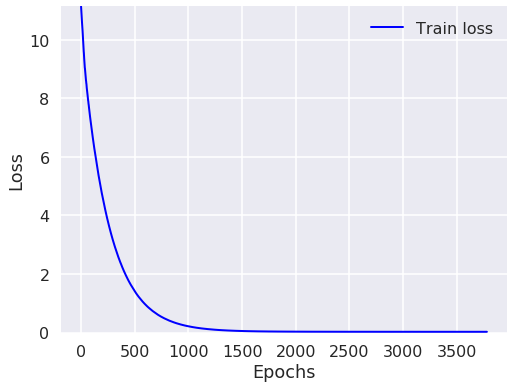


Modelling results: 
train Accuracy = 99.99%, test Accuracy = 99.77% 
train f1-score = 95.96%, test f1-score = 21.69% 
train Cohen Kappa = 0.96, test Cohen Kappa = 0.22 
train Matthews correlation coefficient = 0.96, test Matthews correlation coefficient = 0.22 
train Precision = 0.92, test Precision = 0.24 
train Recall = 1.00, test Recall = 0.20 



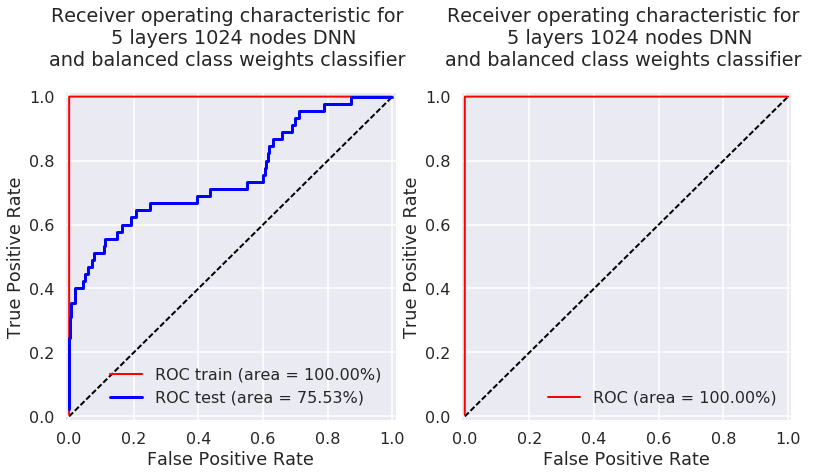


5 layers 1024 nodes DNN



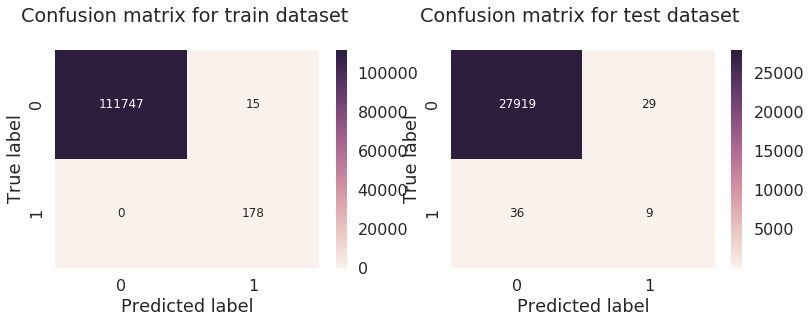


 


DONE


In [27]:
for n_layer in range(2, max_layers+1):
    print("\nTraining model with %d hidden layers, and %d nodes per layer \n" % (n_layer, bins))
    num_hidden = [bins for _ in range(n_layer)]
    #if n_layer % 2 == 0:
    #    gpu = 'gpu:0'
    #else:
    #    gpu = 'gpu:1'
    print("Training on %s" % gpu)
    # maximum training steps
    num_steps = 10001 
    # preparing model for training
    model_DNN_clf = model_DNN_classifier(nh_layers=n_layer, input_dim=bins, drop_out=drop_out,
                                         num_hidden=num_hidden, device=gpu) # constracting model
    # train this model to compare the new function
    start_clf = time.time()
    # verbose progeress every 5%
    out_batch = BatchLogger(display=5) 
    # reduce learning rate if no change in loss for 25 steps 
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.9, patience=50, min_lr=0.00001, verbose=1)
    # stop training in no improving in loss for 100 steps
    stopping = EarlyStopping(monitor='loss', min_delta=0.0, patience=200, verbose=1, mode='auto')
    # fit modle
    model_DNN_clf_h = model_DNN_clf.fit(X_train.values, y_train_class, nb_epoch=num_steps, 
                            batch_size=batch_size, class_weight = cw_tr_dict,
                            #validation_data = (X_test.values, y_test_class, np.array(cw_ts)), # test can be used for validation
                            callbacks=[reduce_lr, stopping, out_batch], verbose=0) # training data entire train dataset
    # show training time
    tr_time_clf = (time.time() - start_clf)/60
    print('Training time is %.2f min' % tr_time_clf)
    # plot train loss history
    plot_train_history(model_DNN_clf_h) 
    # plot ROC curves
    model_DNN_name = str(n_layer)+' layers '+str(bins)+' nodes DNN'
    DNN_performance[model_DNN_name.replace(' ', '')] = ROC_plot(model_DNN_clf, model_DNN_name+'\nand balanced class weights', 
                                                            X_train, y_train_class, X_test, y_test_class, batch_size, DNN=True)
    # show confusion train and test matrixes
    plot_cm_final(model_DNN_clf, model_DNN_name, X_train, y_train_class, X_test, y_test_class, batch_size)
    print("\n=========================================== \n \n")
    
    # saving Keras model
    model_DNN_clf.save(sub_folder+'/'+'DNN_class_'+file_name[:-4]+'_'+str(n_layer)+'layers_DNN_model.h5')  # creates a HDF5 file of the DNN model
    del model_DNN_clf  # deletes the existing model
    
print("\nDONE")

In [28]:
# save results into a data frame
df_performance = pd.DataFrame.from_dict(DNN_performance)

In [29]:
# show data frame
df_performance

2layers1024nodesDNN  3layers1024nodesDNN  \
test  ACC                      99.678491            99.739221   
      AUC                      75.181766            75.104201   
      Cohen_Kappa               0.208987             0.230276   
      Matthews_corr             0.213798             0.230597   
      Precision                 0.173913             0.220000   
      Recall                    0.266667             0.244444   
      f1-score                 21.052632            23.157895   
train ACC                      99.907986            99.958013   
      AUC                      99.999419            99.999661   
      Cohen_Kappa               0.775161             0.883167   
      Matthews_corr             0.795530             0.889257   
      Precision                 0.633452             0.791111   
      Recall                    1.000000             1.000000   
      f1-score                 77.559913            88.337469   

                     4layers1024nodesDNN  5layers1024nodesDNN  
test  ACC                      99.767799            99.767799  
      AUC                      75.314552            75.527010  
      Cohen_Kappa               0.251712             0.215713  
      Matthews_corr             0.251862             0.216487  
      Precision                 0.261905             0.236842  
      Recall                    0.244444             0.200000  
      f1-score                 25.287356            21.686747  
train ACC                      99.976773            99.986600  
      AUC                      99.999701            99.999721  
      Cohen_Kappa               0.931821             0.959502  
      Matthews_corr             0.933995             0.960290  
      Precision                 0.872549             0.922280  
      Recall                    1.000000             1.000000  
      f1-score                 93.193717            95.956873

In [30]:
# save csv file with all results
df_performance.to_csv(sub_folder+'/'+'DNN_class_'+file_name[:-4]+'.csv')

In [31]:
# Example of use model:

# Load a full trained model from disk
#loaded_model_DNN = load_model(sub_folder+'/'+'DNN_class_'+file_name[:-4]+'_'+str(n_layer)+'layers_DNN_model.h5')
# plot train and test results
#ROC_plot(loaded_model_DNN, model_DNN_name, X_train, y_train_class, X_test, y_test_class, batch_size, DNN=True)
# show confusion train and test matrixes
#plot_cm_final(loaded_model_DNN, model_DNN_name, X_train, y_train_class, X_test, y_test_class, batch_size)

# For test or any dataset: print all metices, plot ROC and confusion matrix 
#test_results_plot(loaded_model_DNN, model_DNN_name, X_test, y_test_class, batch_size, DNN=True)